# Convergence of $dG(r_u/r_v)$ time stepping schemes for harmonic oscillator

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
from IPython.display import Math, display

t = symbols("t")
init_printing()

In [2]:
# Choosing some value for the timestep size to visualize the basis functions
_t = np.linspace(0., 1., 100)

In [3]:
# HELPER FUNCTIONS

# compute temporal basis functions from the roots
def compute_basis_functions(roots):
    basis = []
    for i in range(len(roots)):
        f = 1 + 0*Id(t)
        for j in range(len(roots)):
            if i != j:
                f = Mul(f,(t - roots[j]) / (roots[i] - roots[j])) 
        #basis.append(f)
        basis.append(expand(f))
    return basis

# transform roots from [-1, 1] to [0, 1]
def transform_roots(roots):
    new_roots = []
    for root in roots:
        new_roots.append((root + 1) / 2)
    return new_roots
        
# evaluate each basis functions at the time points
# optional: scale basis by basis_coeffs
def get_basis_values(basis, basis_coeffs=None):
    if basis_coeffs is None:
        basis_coeffs = np.ones((len(basis)))
    
    # evaluate basis function at time points
    vals = [np.zeros_like(_t) for _ in range(len(basis))]
    for n in range(len(basis)):
        for i in range(_t.shape[0]):
            vals[n][i] = basis_coeffs[n] * basis[n].evalf(subs={t: _t[i]})
    
    return vals

# get linear combination of basis vector values
def get_basis_lincomb(basis, basis_coeffs):
    vals = get_basis_values(basis, basis_coeffs)
    result = np.zeros_like(vals[0])
    for n in range(len(basis)):
        result += vals[n]
    return result

# plot each basis vector
def plot_basis(basis, title=None):
    basis_vals = get_basis_values(basis)
    
    for n in range(len(basis)):
        plt.plot(_t, basis_vals[n], label=rf"$\varphi_{{{n}}}$")

    plt.xlabel("t")
    plt.ylabel("f(t)")
    plt.legend()
    if title is not None:
        plt.title(title)
    plt.show()

##  Define Gauss-Lobatto temporal FE basis from $r = 0$ to $r = 6$

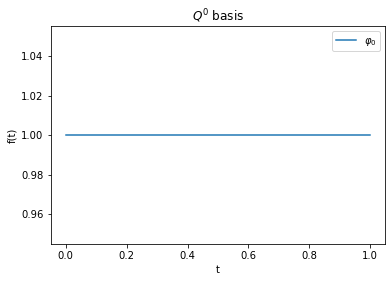

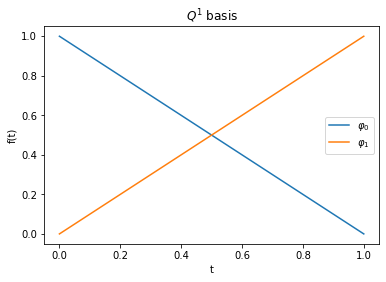

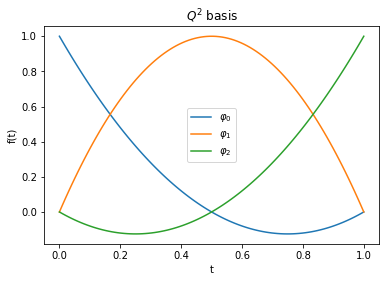

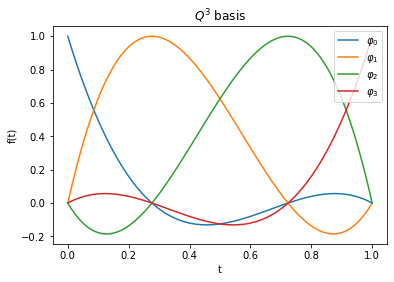

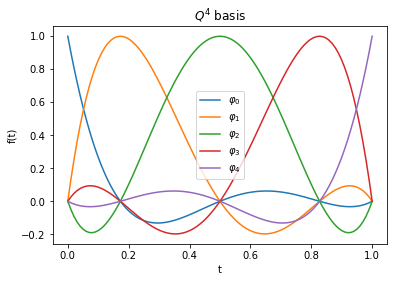

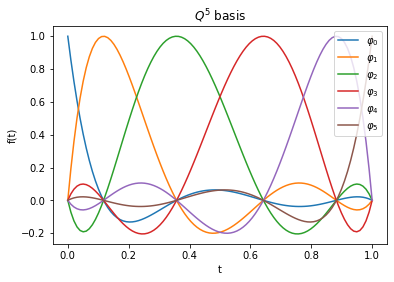

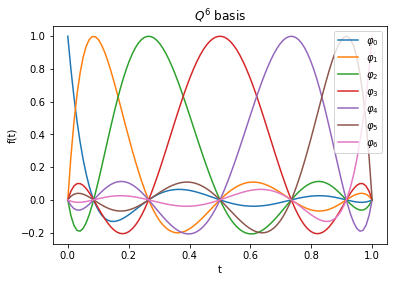

In [4]:
# dictionary of temporal bases depending on the polynomial degree
φ = {}
roots = {}

roots[0] = [1.]
φ[0] = [1 + 0*Id(t)]
roots[1] = [0., 1.]
φ[1] = [1-t, t]
roots[2] = transform_roots([-1, 0, 1])
φ[2] = compute_basis_functions(roots[2])
roots[3] = transform_roots([-1, -sqrt(Rational(1,5)), sqrt(Rational(1,5)), 1])
φ[3] = compute_basis_functions(roots[3])
roots[4] = transform_roots([-1, -sqrt(Rational(3,7)), 0, sqrt(Rational(3,7)), 1])
φ[4] = compute_basis_functions(roots[4])
roots[5] = transform_roots([
    -1, 
    -N(sqrt(Rational(1,3)+sqrt(7)*Rational(2,21))), 
    -N(sqrt(Rational(1,3)-sqrt(7)*Rational(2,21))), 
     N(sqrt(Rational(1,3)-sqrt(7)*Rational(2,21))),
     N(sqrt(Rational(1,3)+sqrt(7)*Rational(2,21))), 
     1
])
φ[5] = compute_basis_functions(roots[5])
roots[6] = transform_roots([
    -1, 
    -N(sqrt(Rational(5,11)+sqrt(Rational(5,3))*Rational(2,11))), 
    -N(sqrt(Rational(5,11)-sqrt(Rational(5,3))*Rational(2,11))),
     0,
     N(sqrt(Rational(5,11)-sqrt(Rational(5,3))*Rational(2,11))),
     N(sqrt(Rational(5,11)+sqrt(Rational(5,3))*Rational(2,11))), 
     1
])
φ[6] = compute_basis_functions(roots[6])

# plot bases from Q^0 to Q^6
for r in range(7):
    plot_basis(basis=φ[r], title=rf"$Q^{{{r}}}$ basis")

## Assemble temporal matrices for $dG(r_u/r_v)$
We assemble the temporal matrices
$$
\begin{align}
M_k^{uu} &= \left\{ \int_{0}^1\varphi_k^{u,(j)}\cdot \varphi_k^{u,(i)}\ \mathrm{d}t \right\}_{i,j = 1}^{r^u+1}, \\
M_k^{vv} &= \left\{ \int_{0}^1\varphi_k^{v,(j)}\cdot \varphi_k^{v,(i)}\ \mathrm{d}t \right\}_{i,j = 1}^{r^v+1}, \\
B_k &= \left\{ \int_{0}^1\partial_t\varphi_k^{(j)}\cdot \varphi_k^{(i)}\ \mathrm{d}t \right\}_{i,j = 1}^{r+1}.
\end{align}
$$
and then transfrom the integrals from $(0,1)$ to $I_m$ by multiplying $M_k^{uu}$ and $M_k^{vv}$ by $k := t_m - t_{m-1}$.

In [5]:
from scipy.integrate import quad

def assemble_mixed_dGr_matrices(r_u, r_v):
    φ_u = φ[r_u]
    φ_v = φ[r_v]
    
    ##################################
    # Create displacement mass matrix
    #
    matrix_M_uu = [] # M_k^{uu}
    for n in range(len(φ_u)):
        matrix_M_uu.append([0.]*len(φ_u))
        
    # Assemble M_k^{uu}
    for i in range(r_u+1):
        for j in range(r_u+1):
            matrix_M_uu[i][j], _ = quad(lambda t_: (φ_u[j] * φ_u[i]).evalf(subs={t: t_}), 0, 1)
            
    ##############################
    # Create velocity mass matrix
    #
    matrix_M_vv = [] # M_k^{vv}
    for n in range(len(φ_v)):
        matrix_M_vv.append([0.]*len(φ_v))
        
    # Assemble M_k^{vv}
    for i in range(r_v+1):
        for j in range(r_v+1):
            matrix_M_vv[i][j], _ = quad(lambda t_: (φ_v[j] * φ_v[i]).evalf(subs={t: t_}), 0, 1)
            
    ########################################
    # Create displacement derivative matrix
    #
    matrix_B_vu = [] # B_k^{vu}
    for n in range(len(φ_v)):
        matrix_B_vu.append([0.]*len(φ_u))
        
    # Assemble B_k^{vu}
    for i in range(r_v+1):
        for j in range(r_u+1):
            matrix_B_vu[i][j], _ = quad(lambda t_: (diff(φ_u[j], t) * φ_v[i]).evalf(subs={t: t_}), 0, 1)
            
    ########################################
    # Create velocity derivative matrix
    #
    matrix_B_uv = [] # B_k^{uv}
    for n in range(len(φ_u)):
        matrix_B_uv.append([0.]*len(φ_v))
        
    # Assemble B_k^{uv}
    for i in range(r_u+1):
        for j in range(r_v+1):
            matrix_B_uv[i][j], _ = quad(lambda t_: (diff(φ_v[j], t) * φ_u[i]).evalf(subs={t: t_}), 0, 1)
    
    return np.array(matrix_M_uu), np.array(matrix_M_vv), np.array(matrix_B_uv), np.array(matrix_B_vu)

matrix_M_uu = {}
matrix_M_vv = {}
matrix_B_uv = {}
matrix_B_vu = {}

for r_u in range(3):
    for r_v in range(3):
        print("--------------------")
        print(f"| r_u = {r_u}, r_v = {r_v} |")
        print("--------------------")
        print("Assembing matrix... ", end="")
        matrix_M_uu[(r_u,r_v)], matrix_M_vv[(r_u,r_v)], matrix_B_uv[(r_u,r_v)], matrix_B_vu[(r_u,r_v)] = assemble_mixed_dGr_matrices(r_u=r_u, r_v=r_v) 
        print("Done.")

        # NOTE: Don't forget adding initial condition to matrix_B, i.e. matrix_B[0][0] += 1
        # Now matrix_B = B_k + D_k^1
        matrix_B_uv[(r_u,r_v)][0][0] += 1.
        matrix_B_vu[(r_u,r_v)][0][0] += 1.

        #print(f"B[{r}] : {matrix_B[r]}")
        #print(f"M[{r}] : {matrix_M[r]}")

--------------------
| r_u = 0, r_v = 0 |
--------------------
Assembing matrix... Done.
--------------------
| r_u = 0, r_v = 1 |
--------------------
Assembing matrix... Done.
--------------------
| r_u = 0, r_v = 2 |
--------------------
Assembing matrix... Done.
--------------------
| r_u = 1, r_v = 0 |
--------------------
Assembing matrix... Done.
--------------------
| r_u = 1, r_v = 1 |
--------------------
Assembing matrix... Done.
--------------------
| r_u = 1, r_v = 2 |
--------------------
Assembing matrix... Done.
--------------------
| r_u = 2, r_v = 0 |
--------------------
Assembing matrix... Done.
--------------------
| r_u = 2, r_v = 1 |
--------------------
Assembing matrix... Done.
--------------------
| r_u = 2, r_v = 2 |
--------------------
Assembing matrix... Done.


## Solve harmonic oscillator ODE with $dG(r_u/r_v)$

--------------------
| r_u = 0, r_v = 0 |
--------------------
--------------------
| r_u = 0, r_v = 1 |
--------------------
--------------------
| r_u = 0, r_v = 2 |
--------------------
--------------------
| r_u = 1, r_v = 0 |
--------------------
--------------------
| r_u = 1, r_v = 1 |
--------------------
--------------------
| r_u = 1, r_v = 2 |
--------------------
--------------------
| r_u = 2, r_v = 0 |
--------------------
--------------------
| r_u = 2, r_v = 1 |
--------------------
--------------------
| r_u = 2, r_v = 2 |
--------------------
{'L2': {(0, 0): [[6.283185307179586, 2.537401900234615], [3.141592653589793, 2.3781295725220732], [1.5707963267948966, 2.092390189993811], [0.7853981633974483, 1.6930626477323965], [0.39269908169872414, 1.2037417397073316], [0.19634954084936207, 0.744786767959727], [0.09817477042468103, 0.41724391797261395], [0.04908738521234052, 0.2210328207498348]], (0, 1): [[6.283185307179586, 2.5451277536290076], [3.141592653589793, 1.6536083

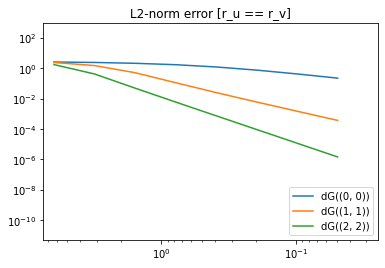

L2-norm error [r_u > r_v]
Slope for dG((1, 0)): -0.7006648562612063
(6.283185307179586,2.2352767775810247)(3.141592653589793,2.6570393341656193)(1.5707963267948966,7266.246009996574)(0.7853981633974483,560.035920307056)(0.39269908169872414,142.1856305129824)(0.19634954084936207,89.52865135984327)(0.09817477042468103,73.43365255120992)(0.04908738521234052,66.95442377026434)
Slope for dG((2, 0)): -0.10356562353600239
(6.283185307179586,2.4038062376839617)(3.141592653589793,2.9320155759601834)(1.5707963267948966,2.8815083757500903)(0.7853981633974483,3.111322055992721)(0.39269908169872414,3.456038118861492)(0.19634954084936207,3.72467205532458)(0.09817477042468103,3.8858754506223)(0.04908738521234052,3.9731409499412416)
Slope for dG((2, 1)): 0.7035215096211042
(6.283185307179586,2.4129765539889703)(3.141592653589793,33.36516656093719)(1.5707963267948966,2.5513523543471095)(0.7853981633974483,1.2914750759149403)(0.39269908169872414,0.6386511531740205)(0.19634954084936207,0.3181143309655732

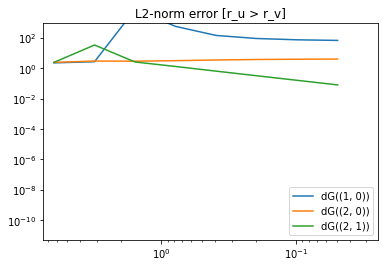

L2-norm error [r_u < r_v]
Slope for dG((0, 1)): -0.6037937793824966
(6.283185307179586,2.5451277536290076)(3.141592653589793,1.653608368113992)(1.5707963267948966,5138.514905599241)(0.7853981633974483,396.3491106686093)(0.39269908169872414,100.85153558076314)(0.19634954084936207,63.610355048227035)(0.09817477042468103,52.22806930117065)(0.04908738521234052,47.64637431899298)
Slope for dG((0, 2)): -0.0448565209781506
(6.283185307179586,2.449950670266513)(3.141592653589793,2.301933186290301)(1.5707963267948966,2.391479402753583)(0.7853981633974483,2.528324608926926)(0.39269908169872414,2.7274290133039063)(0.19634954084936207,2.8901721084466314)(0.09817477042468103,2.990577964475434)(0.04908738521234052,3.0456461747002046)
Slope for dG((1, 2)): 0.6406168718957735
(6.283185307179586,1.778784234666883)(3.141592653589793,93.24609240690624)(1.5707963267948966,3.539551047281894)(0.7853981633974483,1.3915907284618996)(0.39269908169872414,0.6506213637439104)(0.19634954084936207,0.319583441893097

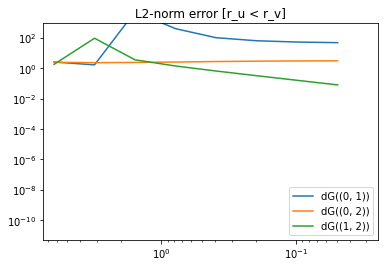

In [14]:
error = {"L2": {}}
T = 2. * np.pi # end time

# solve dG(r_u/r_v) problems
for r_u in range(3):
    for r_v in range(3):
        print("--------------------")
        print(f"| r_u = {r_u}, r_v = {r_v} |")
        print("--------------------")
    
        error["L2"][(r_u, r_v)] = []

        # make solution plotting easier
        evaluation_matrix_u = np.zeros((_t.shape[0], r_u+1))
        for i in range(r_u+1):
            _vec = np.eye(1,r_u+1,i).flatten()
            evaluation_matrix_u[:, i] = get_basis_lincomb(φ[r_u], _vec)

        evaluation_matrix_v = np.zeros((_t.shape[0], r_v+1))
        for i in range(r_v+1):
            _vec = np.eye(1,r_v+1,i).flatten()
            evaluation_matrix_v[:, i] = get_basis_lincomb(φ[r_v], _vec)

        for k in [2.*np.pi*pow(0.5, i) for i in range(0,8)]:
            # assemble system matrix for dG(r_u/r_v)
            system_matrix = np.zeros((r_u+1+r_v+1, r_u+1+r_v+1))
            # diagonal blocks
            system_matrix[:r_u+1, :r_u+1] = k * matrix_M_uu[(r_u, r_v)][:, :]
            system_matrix[r_u+1:, r_u+1:] = -k * matrix_M_vv[(r_u, r_v)][:, :]
            # off-diagonal blocks
            system_matrix[r_u+1:, :r_u+1] = matrix_B_vu[(r_u, r_v)][:, :]
            system_matrix[:r_u+1, r_u+1:] = matrix_B_uv[(r_u, r_v)][:, :]

            # assemble right hand side
            rhs = np.zeros((system_matrix.shape[0],))
            rhs[0] = 1.     # v^0
            rhs[r_v+1] = 0. # u^0
            
            #if r_u == 1 and r_v == 0:
                #print("System matrix:\n", system_matrix)
                #print("Rhs:\n", rhs)
                #input("Enter to continue:")

            solution = []
            time_element = np.array([0., k])
            L2_error = 0.
            while time_element[0] + 1e-10 < T:
                try:
                    solution.append(np.linalg.solve(system_matrix, rhs))

                    time_linspace = time_element[0] + _t*k
                    solution_u_linspace = evaluation_matrix_u.dot(solution[-1][:r_u+1])
                    solution_v_linspace = evaluation_matrix_v.dot(solution[-1][r_u+1:])
                    true_solution_u_linspace = np.sin(time_linspace)
                    true_solution_v_linspace = np.cos(time_linspace)
                    error_u_linspace = np.abs(solution_u_linspace - true_solution_u_linspace)
                    error_v_linspace = np.abs(solution_v_linspace - true_solution_v_linspace)

                    # compute L2 error with trapezoidal rule
                    delta_t = time_linspace[1]-time_linspace[0]
                    L2_error += delta_t * (np.sum(np.power(error_u_linspace[1:-1], 2.)) + 0.5 * (np.power(error_u_linspace[0], 2.) + np.power(error_u_linspace[-1], 2.)) )
                    L2_error += delta_t * (np.sum(np.power(error_v_linspace[1:-1], 2.)) + 0.5 * (np.power(error_v_linspace[0], 2.) + np.power(error_v_linspace[-1], 2.)) )
                    
                    #if r_u != r_v: #r_u == r_v:
                        # plt.plot(time_linspace, solution_u_linspace, color="blue")
                        #plt.plot(time_linspace, error_u_linspace, color="purple")
                        #plt.plot(time_linspace, true_solution_u_linspace, color="orange")
                        # plt.plot(time_linspace, solution_v_linspace, color="green")
                    
                    # set IC for next step
                    rhs[0] = solution[-1][-1] # v^{m-1}
                    rhs[r_u+1] = solution[-1][r_u] # u^{m-1}
                    
                    #if r_u == 1 and r_v == 0:
                        #print("New rhs:\n", rhs)
                        #input("Enter to continue (again):")
                    
                    # prepare next temporal element
                    time_element += k
                except Exception as e:
                    print("Error:", e)
                    print(f"k={k}: Linear system could not be solved.")
                    time_element += k

            error["L2"][(r_u, r_v)].append([k, np.sqrt(L2_error)])
            plt.show() # plot solution or error trajectory

print(error)
        
    
filters = {"==": lambda x, y: x == y, ">": lambda x, y: x > y, "<": lambda x, y: x < y}

for _filter in filters.keys():
    print(f"L2-norm error [r_u {_filter} r_v]")
    plt.title(f"L2-norm error [r_u {_filter} r_v]")
    for r in error["L2"].keys():
        if not filters[_filter](r[0], r[1]):
            continue
        k_vals = [e[0] for e in error["L2"][r] if e[1] > 0.] #1e-11]
        err_vals = [e[1] for e in error["L2"][r] if e[1] > 0.] #1e-11]
        if len(k_vals) > 1:
            x = k_vals
            y = err_vals
            plt.plot(x, y, label=f"dG({r})")
            plt.axis([2.*np.pi*1.2, 2.*np.pi*pow(0.5, 8), 5e-12, 1e3])
            print(f"Slope for dG({r}): {(np.log(y[-1]) - np.log(y[0])) / (np.log(x[-1]) - np.log(x[0]))}")

            for _k, _e in zip(k_vals, err_vals):
                print(f"({_k},{_e})",end="")
            print("")
    plt.legend(loc="lower right")
    plt.xscale("log")
    plt.yscale("log")
    plt.show()

In [15]:
matrix_M_uu[(1,0)]

array([[0.33333333, 0.16666667],
       [0.16666667, 0.33333333]])

In [16]:
matrix_M_vv[(1,0)]

array([[1.]])

In [17]:
matrix_B_uv[(1,0)]

array([[1.],
       [0.]])

In [18]:
matrix_B_vu[(1,0)]

array([[0., 1.]])